# Finding Shaker table sync cues in ACC measurements from Equivitals

having issues with datetime 
https://pandas.pydata.org/docs/whatsnew/v2.2.0.html#datetimelike

https://github.com/pandas-dev/pandas/issues/52895
Work around for now: plt.plot(df.col_in_dt,df.col_signal)

For now, convert all datetimes to utc with .tz_localize(None), .dt.tz_localize(None), and custom remove_tz_from_dataframe function

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al

In [3]:
pip show pandas | grep Version

Version: 2.2.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%reload_ext autoreload

In [6]:
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ col for col in df.columns if any([isinstance(x, pd.Timestamp) for x in df[col]])]
    for col in col_times:
        df[col] = pd.to_datetime(df[col],format='ISO8601') 
        df[col] = df[col].dt.tz_localize(None) 
    return df

def xcov(datax, datay,maxlag=10):
    # https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
    rs = []
    for i in range(-maxlag,maxlag):
        rs.append(datax.corr(datay.shift(i)))
    return rs

In [7]:
def min_align(ACC,cue,prelim_synch_time,max_offs):   
    sampleshift_s = cue['sTime'].diff().median()
    sf = np.round(1/sampleshift_s)
    t_range = [cue['sTime'].iloc[0],cue['sTime'].iloc[-1]]
    c_type = 'taps'
    xrange = [pd.to_timedelta(t_range[0],unit = 's') + prelim_synch_time,
              pd.to_timedelta(t_range[1],unit = 's') + prelim_synch_time]
#     print(xrange)
    sig_sTime = cue['sTime'].values #np.linspace(t_range[0],t_range[1],sf*(t_range[1]-t_range[0]),endpoint=False)
    cue.loc[:,'dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time

    max_offs = 5
    X = al.dt_cut(ACC,'dev_dTime',xrange[0],xrange[1])
    sig_t = (X['dev_dTime'].dt.tz_localize(None) - prelim_synch_time.tz_localize(None)).dt.total_seconds()
    sig_v = X['signal']
    f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
    new_sig = f(sig_sTime)
    signal = pd.DataFrame()
    signal.loc[:,'signal'] = new_sig
    signal.loc[signal['signal'].isna(),'signal'] = 0
    # scale signals a little 
    M = signal['signal'].quantile(0.998)
    signal.loc[:,'signal']  = signal['signal']/M
    signal.loc[signal['signal']>1,'signal'] = 1
    signal.loc[signal['signal']<0,'signal'] = 0
    signal.loc[:,'sTime'] = sig_sTime
    signal.loc[:,'dev_dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time.tz_localize(None)
    length = np.min([len(signal),len(cue)]) # they should match, but just in case

    xcorred = pd.DataFrame()
    max_offs = 5
    xcorred['shift_s'] = np.linspace(-max_offs,max_offs,int(2*max_offs*sf), endpoint=False) 
    xcorred['r'] = xcov(cue[c_type].iloc[:length], signal['signal'].iloc[:length],int(max_offs*sf))
    max_shift = xcorred.loc[xcorred['r'].argmax(),'shift_s']
    max_r = xcorred['r'].max()
    cue.loc[:,'dev_dTime'] = cue['dTime'] - pd.to_timedelta(max_shift,unit='s')

    fig, axes = plt.subplots(3,1,figsize=(12,4))
    ax =axes[0]
    cue.plot(x='sTime',y=c_type,ax=ax)
    signal.plot(x='sTime',y='signal',label='ACC',ax=ax)
    ax.set_title('ACC synch alignment')
    ax.set_ylabel('Unaligned')
    ax.legend()

    ax = axes[1]
    xcorred.plot(x='shift_s',y='r',ax=ax)
    ax.plot(max_shift,max_r,'ro')
    ax.set_ylim([0,1])
    ax.grid(True)
    ax.set_xticklabels('')

    ax = axes[2]
    ax.plot(cue['dev_dTime'],cue[c_type],label=c_type)
    ax.plot(signal['dev_dTime'],signal['signal'],label='ACC')
    ax.xaxis.set_tick_params(rotation=40)

    ax.grid(True)
    ax.set_title('shift '+ str(np.round(max_shift,3))+ ' s')
    ax.set_ylabel('Aligned')
    ax.set_xlabel('dev_Time')
    plt.show()

    cue_time = cue.loc[cue['peaks']==1,'dev_dTime'].iloc[0].tz_localize(None) 
    C_results = {'best_dt': cue_time,'best_s': max_shift,'best_r': max_r,'CCC':xcorred,'cue':cue,'signal':signal}
    return C_results

# Get the cues for Wednesday March 6th

In [8]:
synch_times = {}

In [40]:
cue_times.loc[cue_times['peaks']==1,'DateTime']

429.968750   2024-03-06 07:12:08.000000000
431.648438   2024-03-06 07:12:09.679687500
433.441406   2024-03-06 07:12:11.472656250
435.062500   2024-03-06 07:12:13.093750000
Name: DateTime, dtype: datetime64[ns]

In [9]:
cue_times = pd.read_csv('./outfiles/cue1_acc_20240306.csv',index_col = 0)
# cue2_acc_20240304.csv#SV alignment for beeps
cue_times['DateTime'] = pd.to_datetime(cue_times['DateTime'],format='ISO8601')
cue_times['S_AudioTime'] = np.round(cue_times.index,4)
Sync_Zero_Time_s = cue_times.loc[cue_times['peaks']==1,'S_AudioTime'].iloc[0]
Sync_Zero_Time_dt = cue_times.loc[cue_times['peaks']==1,'DateTime'].iloc[0].tz_localize(None) 
synch_times['cue1_20240306'] = Sync_Zero_Time_dt
cue_times['SyncTime'] = cue_times['S_AudioTime']-Sync_Zero_Time_s # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['peaks']==1,'SyncTime']
peak_times

429.968750    0.0000
431.648438    1.6796
433.441406    3.4726
435.062500    5.0937
Name: SyncTime, dtype: float64

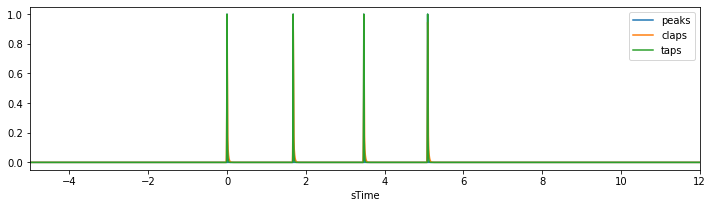

In [10]:
CueT={}
sf = 256
t_range= [-5,12]
cue = al.cue_template_make(peak_times,sf,t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])
plt.xlim(t_range)

CueT['cue1_20240306'] = cue

In [11]:
Sync_Zero_Time_dt

Timestamp('2024-03-06 07:12:08')

In [12]:
synch_times

{'cue1_20240306': Timestamp('2024-03-06 07:12:08')}

In [13]:
CueT

{'cue1_20240306':           sTime  peaks           taps  claps
 0     -5.000000      0   0.000000e+00    0.0
 1     -4.996094      0   0.000000e+00    0.0
 2     -4.992188      0   0.000000e+00    0.0
 3     -4.988281      0   0.000000e+00    0.0
 4     -4.984375      0   0.000000e+00    0.0
 ...         ...    ...            ...    ...
 4347  11.980469      0  1.778608e-311    0.0
 4348  11.984375      0  1.185739e-311    0.0
 4349  11.988281      0  7.904925e-312    0.0
 4350  11.992188      0   0.000000e+00    0.0
 4351  11.996094      0   0.000000e+00    0.0
 
 [4352 rows x 4 columns]}

## Load example of ACC data

In [91]:
# note special complications: VN104 was not returned on march 04, recorded through to late on march 05
# LS404 was also late on March 05. These need to be synched with Synch 3. 

data_dir='/Volumes/TaeTae/Stavangar/20240307/Extracted SEM Data/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]
pid='VN101'
df_datafiles.loc[pid,:]

In [19]:
data_dir='/Volumes/Seagatehub/BiC2024/20240306/Equivital/Extracted SEM Data/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]

,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
DevName,,,,,,,,,,,,,,,,,,,,,
VN101,DATA,3420415,240306,0,DATA-VN101-3420415-24030600.CSV,csv,108868,2024-03-06 07:01:28+00:00,2024-03-06 12:18:58+00:00,19050.0,...,[VN101],3420415.0,VN101,53.0,69,98.0,0.0,0.0,MovingSlowly,Upright
VN104,DATA,3420456,240306,101,DATA-VN104-3420456-24030600_0.CSV,csv,107663,2024-03-06 07:01:29+00:00,2024-03-06 12:17:59+00:00,18990.0,...,[VN104],3420456.0,VN104,53.0,83,98.0,0.0,0.0,Stationary,Upright
VN105,DATA,3420755,240306,0,DATA-VN105-3420755-24030600.CSV,csv,107418,2024-03-06 07:01:31+00:00,2024-03-06 12:19:03+00:00,19052.0,...,[VN105],3420755.0,VN105,53.0,0,98.0,0.0,0.0,Stationary,Upright
VN109,DATA,5022010,240306,0,DATA-VN109-5022010-24030600.CSV,csv,107678,2024-03-06 07:01:31+00:00,2024-03-06 12:19:01+00:00,19050.0,...,[VN109],5022010.0,VN109,53.0,81,98.0,0.0,0.0,Stationary,Upright
VN110,DATA,5022026,240306,0,DATA-VN110-5022026-24030600.CSV,csv,107918,2024-03-06 07:01:35+00:00,2024-03-06 12:19:05+00:00,19050.0,...,[VN110],5022026.0,VN110,53.0,79,98.0,0.0,0.0,Stationary,Upright


In [20]:
df_datafiles.columns
df_datafiles

,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
DevName,,,,,,,,,,,,,,,,,,,,,
VN101,DATA,3420415,240306,0,DATA-VN101-3420415-24030600.CSV,csv,108868,2024-03-06 07:01:28+00:00,2024-03-06 12:18:58+00:00,19050.0,...,[VN101],3420415.0,VN101,53.0,69,98.0,0.0,0.0,MovingSlowly,Upright
VN104,DATA,3420456,240306,101,DATA-VN104-3420456-24030600_0.CSV,csv,107663,2024-03-06 07:01:29+00:00,2024-03-06 12:17:59+00:00,18990.0,...,[VN104],3420456.0,VN104,53.0,83,98.0,0.0,0.0,Stationary,Upright
VN105,DATA,3420755,240306,0,DATA-VN105-3420755-24030600.CSV,csv,107418,2024-03-06 07:01:31+00:00,2024-03-06 12:19:03+00:00,19052.0,...,[VN105],3420755.0,VN105,53.0,0,98.0,0.0,0.0,Stationary,Upright
VN109,DATA,5022010,240306,0,DATA-VN109-5022010-24030600.CSV,csv,107678,2024-03-06 07:01:31+00:00,2024-03-06 12:19:01+00:00,19050.0,...,[VN109],5022010.0,VN109,53.0,81,98.0,0.0,0.0,Stationary,Upright
VN110,DATA,5022026,240306,0,DATA-VN110-5022026-24030600.CSV,csv,107918,2024-03-06 07:01:35+00:00,2024-03-06 12:19:05+00:00,19050.0,...,[VN110],5022026.0,VN110,53.0,79,98.0,0.0,0.0,Stationary,Upright
VN111,DATA,5022027,240306,0,DATA-VN111-5022027-24030600.CSV,csv,107913,2024-03-06 07:01:35+00:00,2024-03-06 12:18:20+00:00,19005.0,...,[VN111],5022027.0,VN111,53.0,80,95.0,0.0,0.0,Stationary,Upright
VN206,DATA,5022062,240306,0,DATA-VN206-5022062-24030600.CSV,csv,107062,2024-03-06 07:02:53+00:00,2024-03-06 12:17:53+00:00,18900.0,...,[VN206],5022062.0,VN206,53.0,66,99.0,0.0,0.0,Stationary,Upright
VN201,DATA,5022050,240306,0,DATA-VN201-5022050-24030600.CSV,csv,107890,2024-03-06 07:02:53+00:00,2024-03-06 12:20:08+00:00,19035.0,...,[VN201],5022050.0,VN201,53.0,75,97.0,0.0,0.0,Stationary,Upright
VN211,DATA,5022247,240306,0,DATA-VN211-5022247-24030600.CSV,csv,107380,2024-03-06 07:02:55+00:00,2024-03-06 12:18:40+00:00,18945.0,...,[VN211],5022247.0,VN211,53.0,77,97.0,0.0,0.0,Stationary,Upright


In [21]:
df_datafiles.iloc[:5,:]
pid='PC709'
df_datafiles.loc[pid,:]

Signal                                                            DATA
ID                                                             5022299
Date                                                            240306
Session                                                            101
FileName                             DATA-PC709-5022299-24030600_0.CSV
FileType                                                           csv
FileSize                                                        107492
RecStart                                     2024-03-06 07:05:29+00:00
RecEnd                                       2024-03-06 12:22:59+00:00
Duration                                                       19050.0
BatteryStart                                                      4088
BatteryEnd                                                        3959
BatteryChange(mV)                                                 -129
FullLoc              /Volumes/Seagatehub/BiC2024/20240306/Equivital...
DATAlo

In [22]:
V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
# V = pd.read_csv('./testing/FASTACC-BR604-5022198-24030700.CSV',skipinitialspace=True)

ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
ACC = remove_tz_from_dataframe(ACC)
ACC.loc[:5,:]

,dev_dTime,signal
0,2024-03-06 07:05:01.007,0.0
1,2024-03-06 07:05:01.011,0.0
2,2024-03-06 07:05:01.015,0.0
3,2024-03-06 07:05:01.019,0.0
4,2024-03-06 07:05:01.023,0.0
5,2024-03-06 07:05:01.027,0.0


In [23]:
c = 'cue1_20240306'

In [24]:
synch_times[c]

Timestamp('2024-03-06 07:12:08')

7680


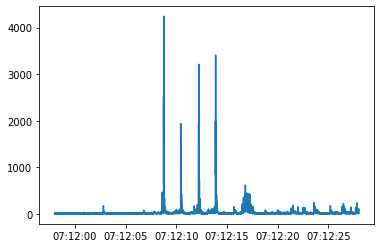

In [26]:
dt_0 = synch_times[c]-pd.to_timedelta(10,unit='s')
dt_1 = synch_times[c]+pd.to_timedelta(20,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
print(len(ACC_ex))
plt.plot(ACC_ex['dev_dTime'],ACC_ex['signal'])

In [28]:
# it seems the clocks on the equivitals are nearly 30 s of from the time selected in the cue findings. 
# We can fix this in TimeAlign/Shake_Audio_Cue.ipynb

c = 'cue1_20240306'
cue = CueT[c].copy()
prelim_synch_time = (synch_times[c]+pd.to_timedelta(0,unit='s')).tz_localize(None)
print(prelim_synch_time)
cue

2024-03-06 07:12:08


,sTime,peaks,taps,claps
0,-5.000000,0,0.000000e+00,0.0
1,-4.996094,0,0.000000e+00,0.0
2,-4.992188,0,0.000000e+00,0.0
3,-4.988281,0,0.000000e+00,0.0
4,-4.984375,0,0.000000e+00,0.0
...,...,...,...,...
4347,11.980469,0,1.778608e-311,0.0
4348,11.984375,0,1.185739e-311,0.0
4349,11.988281,0,7.904925e-312,0.0
4350,11.992188,0,0.000000e+00,0.0


In [29]:
sampleshift_s = cue['sTime'].diff().median()
sf = np.round(1/sampleshift_s)
t_range = [cue['sTime'].iloc[0],cue['sTime'].iloc[-1]]
c_type = 'taps'
xrange = [pd.to_timedelta(t_range[0],unit = 's') + prelim_synch_time,
          pd.to_timedelta(t_range[1],unit = 's') + prelim_synch_time]
sig_sTime = cue['sTime'].values #np.linspace(t_range[0],t_range[1],sf*(t_range[1]-t_range[0]),endpoint=False)
cue.loc[:,'dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time

max_offs = 5
X = al.dt_cut(ACC,'dev_dTime',xrange[0],xrange[1])
sig_t = (X['dev_dTime'].dt.tz_localize(None) - prelim_synch_time.tz_localize(None)).dt.total_seconds()
sig_v = X['signal']
f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
new_sig = f(sig_sTime)
signal = pd.DataFrame()
signal.loc[:,'signal'] = new_sig
signal.loc[signal['signal'].isna(),'signal'] = 0
# scale signals a little 
M = signal['signal'].quantile(0.998)
signal.loc[:,'signal']  = signal['signal']/M
signal.loc[signal['signal']>1,'signal'] = 1
signal.loc[signal['signal']<0,'signal'] = 0
signal.loc[:,'sTime'] = sig_sTime
signal.loc[:,'dev_dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time.tz_localize(None)
length = np.min([len(signal),len(cue)]) # they should match, but just in case
# plt.plot(cue['dTime'],cue['taps'])

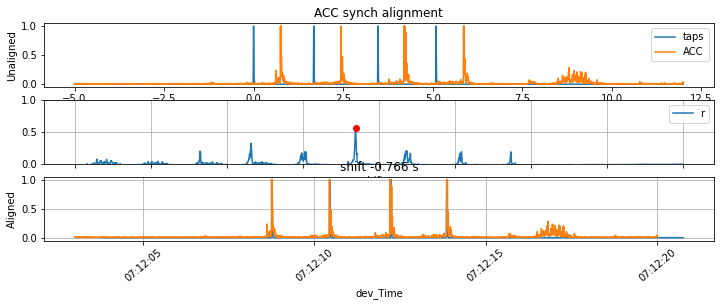

2024-03-06 07:12:08.765625


In [30]:
xcorred = pd.DataFrame()
max_offs = 10
xcorred['shift_s'] = np.linspace(-max_offs,max_offs,int(2*max_offs*sf), endpoint=False) 
xcorred['r'] = xcov(cue[c_type].iloc[:length], signal['signal'].iloc[:length],int(max_offs*sf))
max_shift = xcorred.loc[xcorred['r'].argmax(),'shift_s']
max_r = xcorred['r'].max()
cue.loc[:,'dev_dTime'] = cue['dTime'] - pd.to_timedelta(max_shift,unit='s')

fig, axes = plt.subplots(3,1,figsize=(12,4))
ax =axes[0]
cue.plot(x='sTime',y=c_type,ax=ax)
signal.plot(x='sTime',y='signal',label='ACC',ax=ax)
ax.set_title('ACC synch alignment')
ax.set_ylabel('Unaligned')
ax.legend()

ax = axes[1]
xcorred.plot(x='shift_s',y='r',ax=ax)
ax.plot(max_shift,max_r,'ro')
ax.set_ylim([0,1])
ax.grid(True)
ax.set_xticklabels('')

ax = axes[2]
ax.plot(cue['dev_dTime'],cue[c_type],label=c_type)
ax.plot(signal['dev_dTime'],signal['signal'],label='ACC')
ax.xaxis.set_tick_params(rotation=40)

ax.grid(True)
ax.set_title('shift '+ str(np.round(max_shift,3))+ ' s')
ax.set_ylabel('Aligned')
ax.set_xlabel('dev_Time')
plt.show()

cue_time = cue.loc[cue['peaks']==1,'dev_dTime'].iloc[0].tz_localize(None) 
C_results = {'best': cue_time,'CCC':xcorred,'cue':cue,'signal':signal}
print(cue_time)

In [31]:
synch_times[c] # 2024-03-04 07:56:25.579206250

Timestamp('2024-03-06 07:12:08')

# Running through the sensors

['VN101', 31.641445875167847]


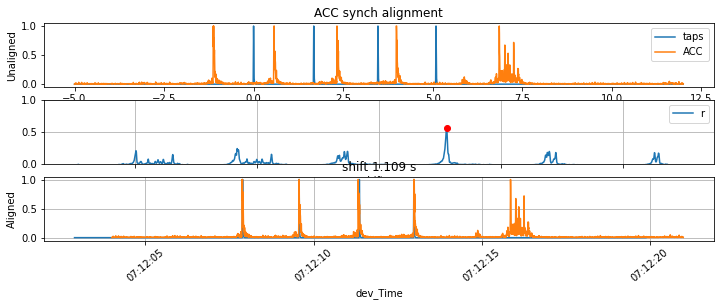

['VN104', 50.26822471618652]


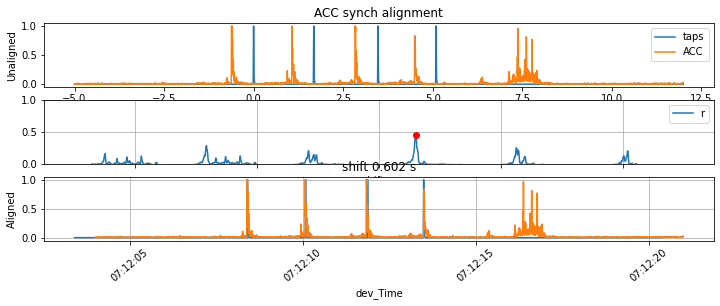

['VN105', 69.07696485519409]


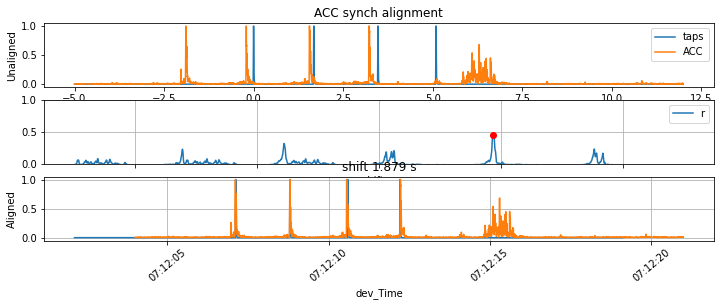

['VN109', 88.48710560798645]


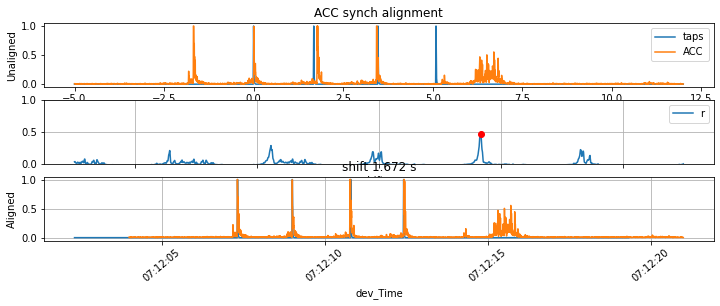

['VN110', 110.46336674690247]


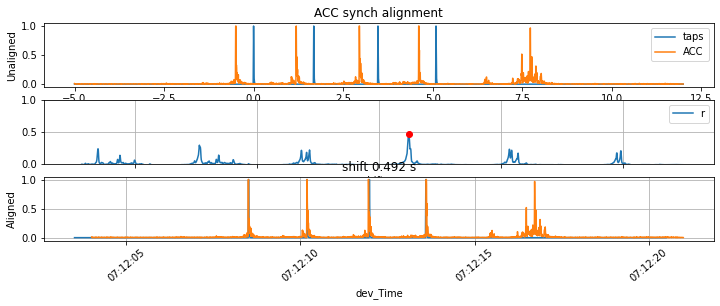

['VN111', 129.89031672477722]


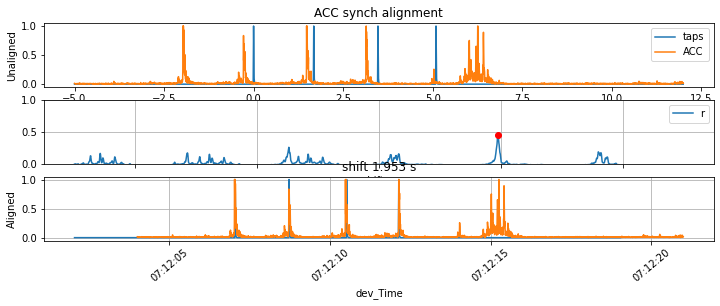

['VN206', 147.92500567436218]


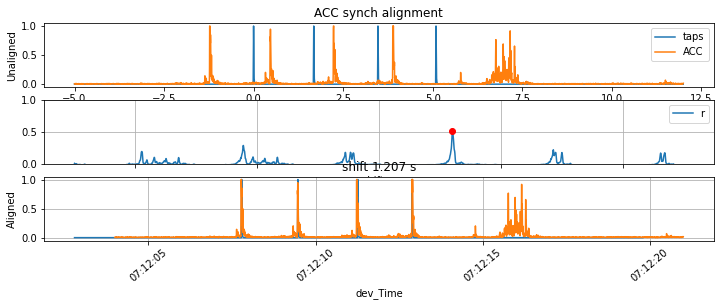

['VN201', 166.30871176719666]


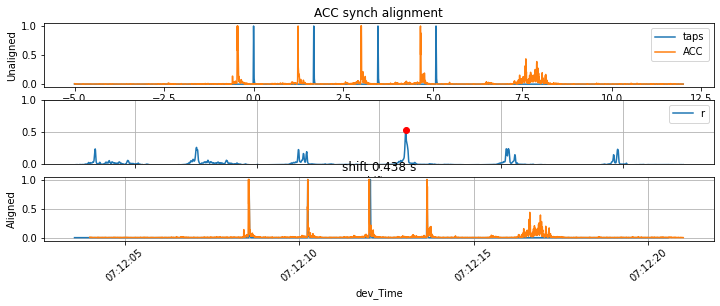

['VN211', 184.30965876579285]


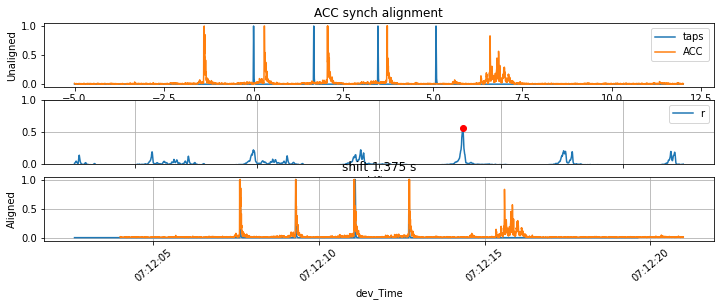

['VN212', 202.23022389411926]


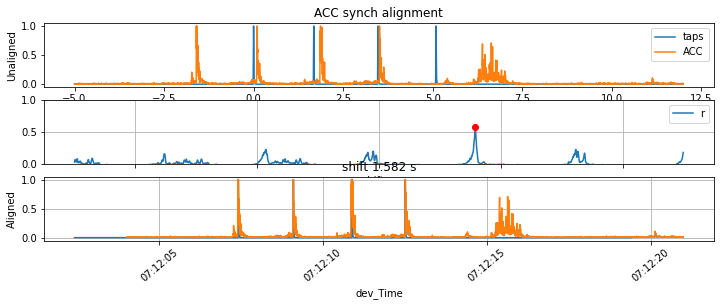

['VA305', 220.2547047138214]


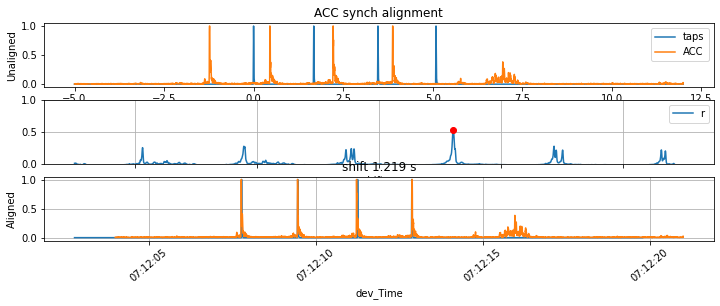

['VA309', 238.3060097694397]


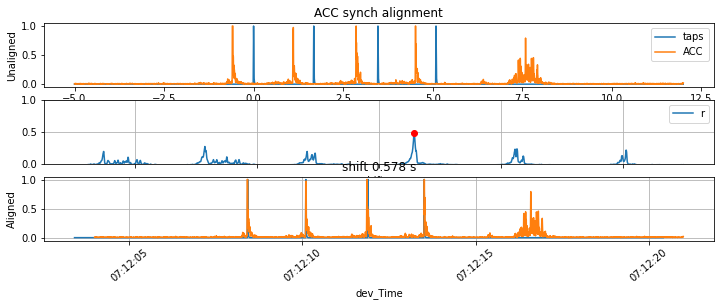

['LS407', 256.4983458518982]


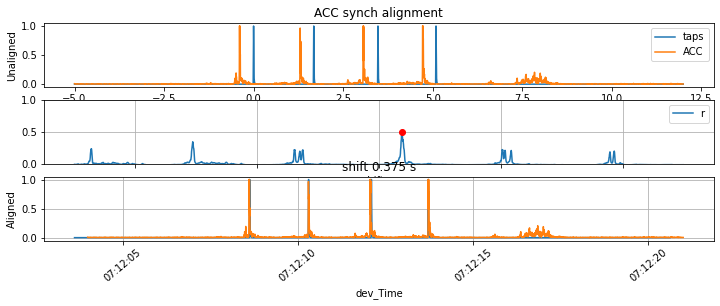

['LS410', 274.6117317676544]


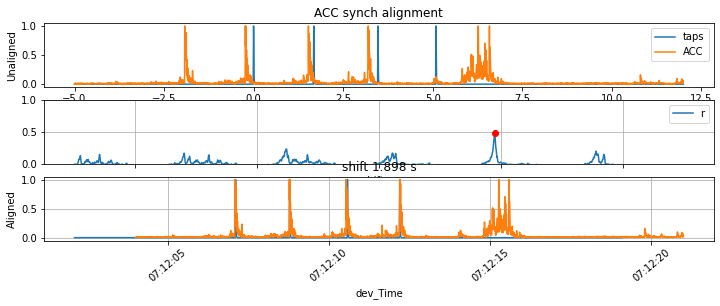

['LS409', 294.1897909641266]


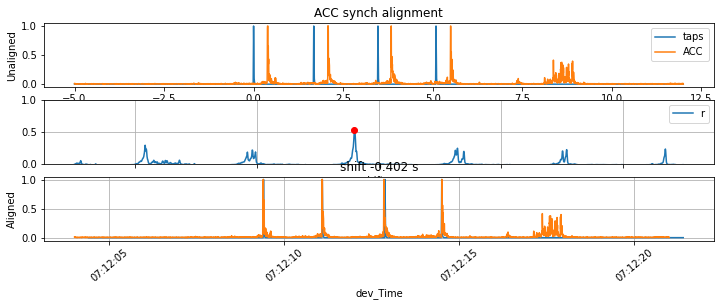

['LS401', 312.341739654541]


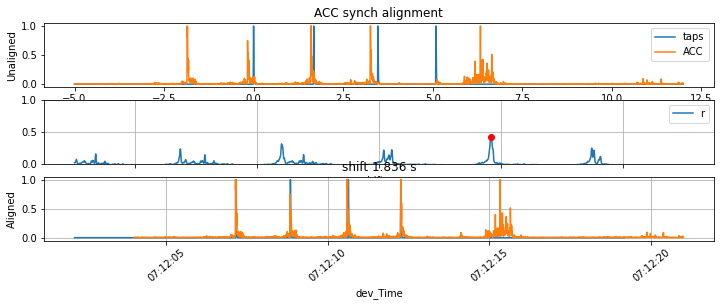

['LS404', 330.310284614563]


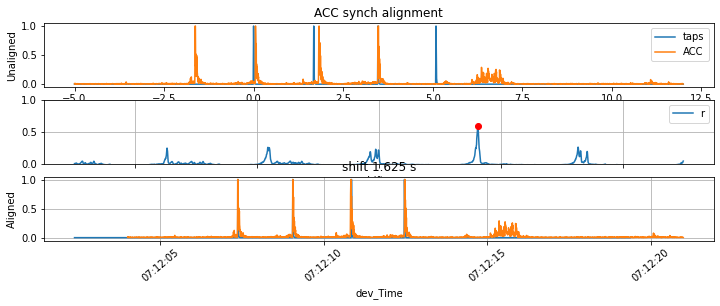

['LS405', 348.28203773498535]


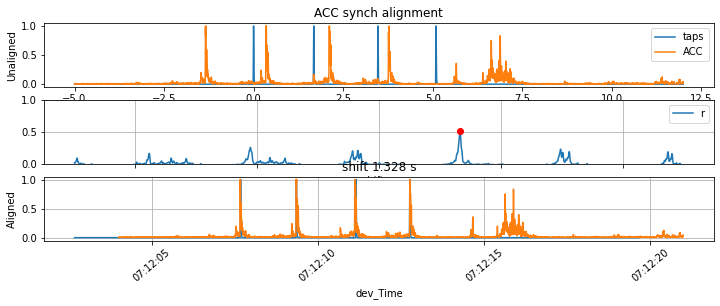

['WW504', 366.2468647956848]


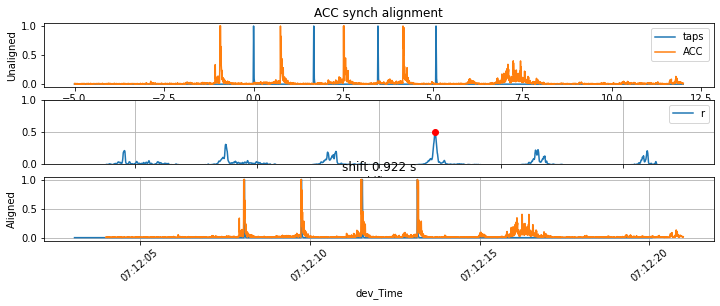

['WW506', 384.0673637390137]


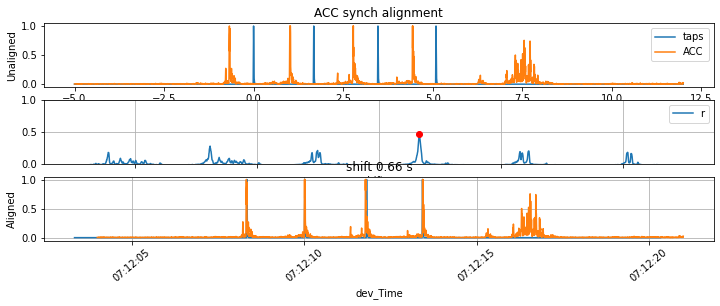

['WW508', 402.3284659385681]


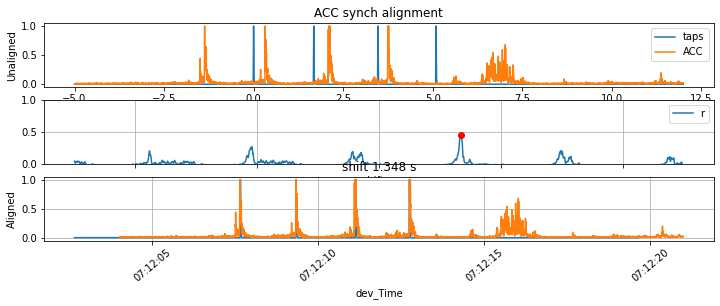

['BR604', 420.55285573005676]


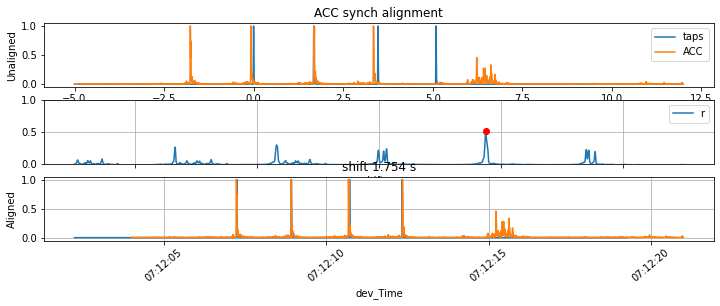

['BR605', 438.419038772583]


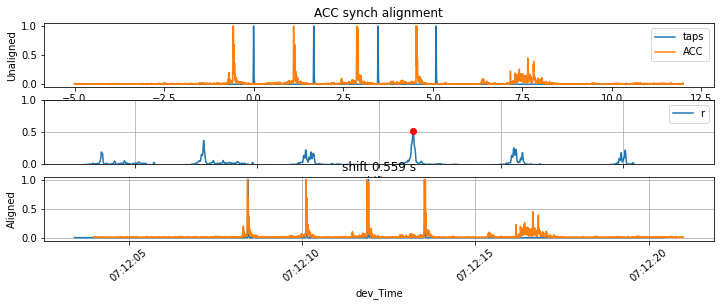

['BR606', 456.1654028892517]


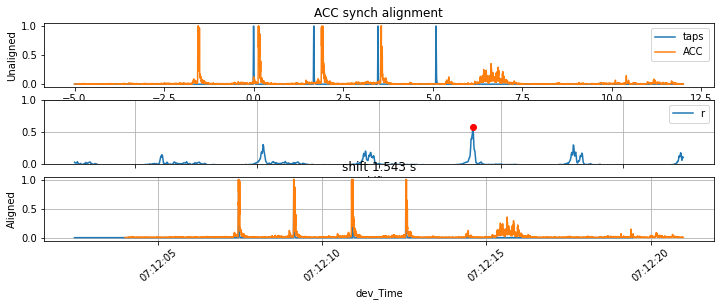

['BR608', 474.0714519023895]


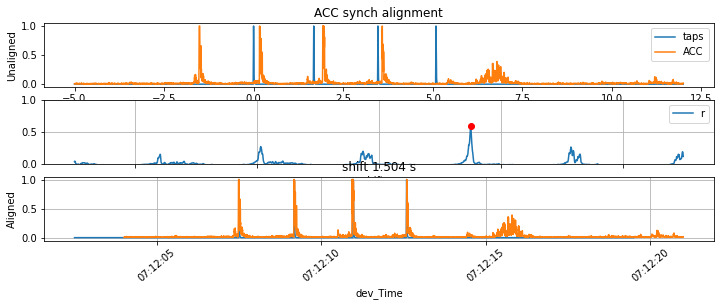

['BR609', 492.1285219192505]


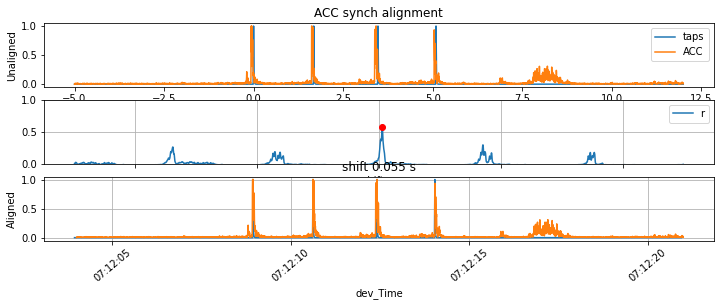

['PC702', 509.84311985969543]


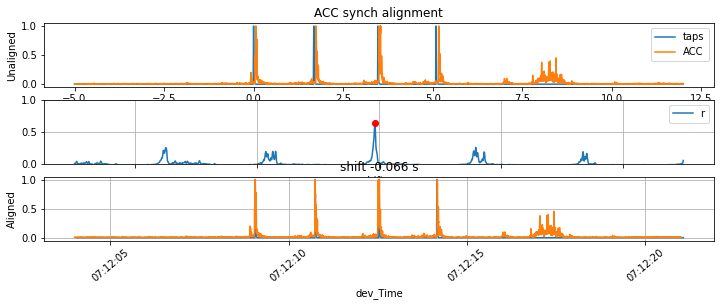

['PC710', 527.5622637271881]


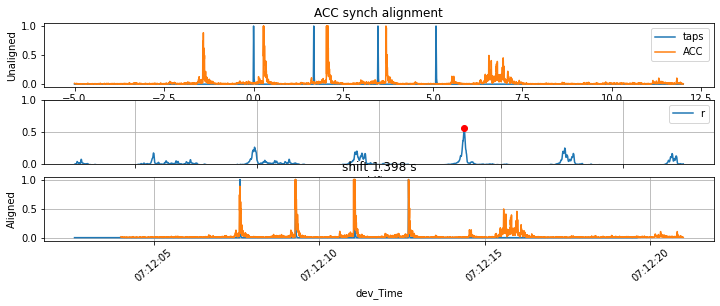

['PC709', 545.8040897846222]


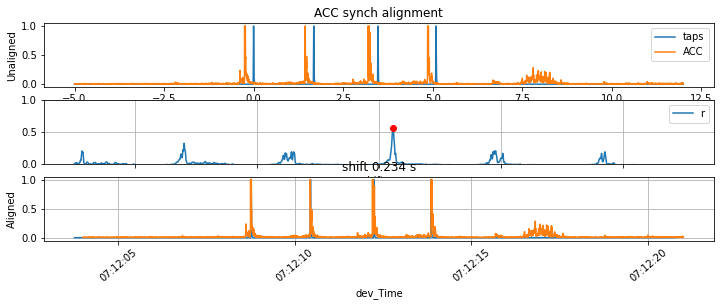

['VA304', 563.8050167560577]


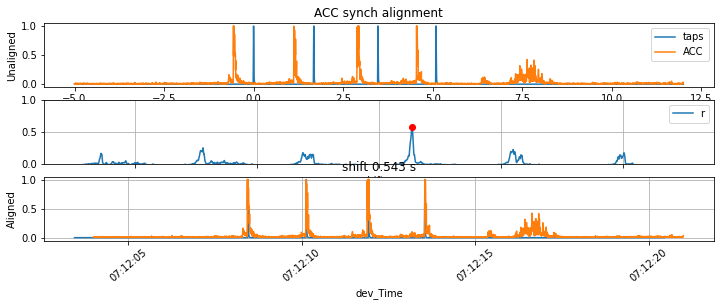

564.895587682724


,Cue1_devdTime,Cue1_s,Cue1_r
DevName,,,
VN101,2024-03-06 07:12:07.890625,1.109375,0.566995
VN104,2024-03-06 07:12:08.398437500,0.601562,0.453916
VN105,2024-03-06 07:12:07.121093750,1.878906,0.450958
VN109,2024-03-06 07:12:07.328125,1.671875,0.469074
VN110,2024-03-06 07:12:08.507812500,0.492188,0.469037
VN111,2024-03-06 07:12:07.046875,1.953125,0.447598
VN206,2024-03-06 07:12:07.792968750,1.207031,0.516876
VN201,2024-03-06 07:12:08.562500,0.4375,0.536402
VN211,2024-03-06 07:12:07.625000,1.375,0.556636


In [32]:
df_shifts = pd.DataFrame(index = df_datafiles.index,columns = ['Cue1_devdTime','Cue1_s','Cue1_r'])
tic = time.time()
t_center = 1

for pid,row in df_datafiles.iterrows():
#     if pid in ['VA302','PC702','PC705']:
#     if pid not in ['BLUETOOTH01','BLUETOOTH02','BLUETOOTH03','BLUETOOTH04']:
    V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
    ACC = pd.DataFrame()
    ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])
    df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
    ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
    ACC = remove_tz_from_dataframe(ACC)
    print([pid,time.time()-tic])

    dt_0 = synch_times['cue1_20240306']-pd.to_timedelta(25,unit='s')
    dt_1 = synch_times['cue1_20240306']+pd.to_timedelta(25,unit='s')
    ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
    maxlag_s = 5
    results = min_align(ACC_ex,CueT['cue1_20240306'].copy(),(synch_times['cue1_20240306']+pd.to_timedelta(t_center,unit='s')).tz_localize(None),maxlag_s)
    df_shifts.loc[pid,'Cue1_devdTime'] = results['best_dt']
    df_shifts.loc[pid,'Cue1_s'] = results['best_s']
    df_shifts.loc[pid,'Cue1_r'] = results['best_r']

print(time.time()-tic)
df_shifts

In [33]:
[df_shifts['Cue1_s'].mean()]

[1.040625]

In [34]:
df_shifts['devID'] = df_datafiles['ID']
df_shifts['ACCFile'] = df_datafiles['ACCloc']

In [43]:
df_shifts['devID'] = df_datafiles['ID']
df_shifts['ACCFile'] = df_datafiles['ACCloc']
df_shifts['Cue1_file'] = './outfiles/cue1_acc_20240306.csv'
df_shifts['Cue1_name'] = c
df_shifts['Cue1_dt'] = synch_times[c]
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,devID,ACCFile,Cue_file,Cue_name,Cue_dt,Cue1_file,Cue1_name,Cue1_dt
DevName,,,,,,,,,,,
VN101,2024-03-06 07:12:07.890625,1.109375,0.566995,3420415,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08
VN104,2024-03-06 07:12:08.398437500,0.601562,0.453916,3420456,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08
VN105,2024-03-06 07:12:07.121093750,1.878906,0.450958,3420755,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08
VN109,2024-03-06 07:12:07.328125,1.671875,0.469074,5022010,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08
VN110,2024-03-06 07:12:08.507812500,0.492188,0.469037,5022026,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08
VN111,2024-03-06 07:12:07.046875,1.953125,0.447598,5022027,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08
VN206,2024-03-06 07:12:07.792968750,1.207031,0.516876,5022062,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08
VN201,2024-03-06 07:12:08.562500,0.4375,0.536402,5022050,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08
VN211,2024-03-06 07:12:07.625000,1.375,0.556636,5022247,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08


In [42]:
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,devID,ACCFile,Cue_file,Cue_name,Cue_dt
DevName,,,,,,,,
VN101,2024-03-06 07:12:07.890625,1.109375,0.566995,3420415,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08
VN104,2024-03-06 07:12:08.398437500,0.601562,0.453916,3420456,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08
VN105,2024-03-06 07:12:07.121093750,1.878906,0.450958,3420755,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08
VN109,2024-03-06 07:12:07.328125,1.671875,0.469074,5022010,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08
VN110,2024-03-06 07:12:08.507812500,0.492188,0.469037,5022026,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08
VN111,2024-03-06 07:12:07.046875,1.953125,0.447598,5022027,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08
VN206,2024-03-06 07:12:07.792968750,1.207031,0.516876,5022062,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08
VN201,2024-03-06 07:12:08.562500,0.4375,0.536402,5022050,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08
VN211,2024-03-06 07:12:07.625000,1.375,0.556636,5022247,/Volumes/Seagatehub/BiC2024/20240306/Equivital...,./outfiles/cue1_acc_20240306.csv,cue1_20240306,2024-03-06 07:12:08


In [36]:
df_shifts.to_csv('./outfiles/Cue_ACC_dev_align_20240306.csv')
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,devID
DevName,,,,
VN101,2024-03-06 07:12:07.890625,1.109375,0.566995,3420415
VN104,2024-03-06 07:12:08.398437500,0.601562,0.453916,3420456
VN105,2024-03-06 07:12:07.121093750,1.878906,0.450958,3420755
VN109,2024-03-06 07:12:07.328125,1.671875,0.469074,5022010
VN110,2024-03-06 07:12:08.507812500,0.492188,0.469037,5022026
VN111,2024-03-06 07:12:07.046875,1.953125,0.447598,5022027
VN206,2024-03-06 07:12:07.792968750,1.207031,0.516876,5022062
VN201,2024-03-06 07:12:08.562500,0.4375,0.536402,5022050
VN211,2024-03-06 07:12:07.625000,1.375,0.556636,5022247
